In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
def parse_dataset(filename, x1, x2):
    datapoints = []
    df = pd.read_csv(filename)
    for x_val, y_val in zip(df[x1], df[x2]):
        datapoints.append([x_val, y_val])
    return datapoints

def form_neighbors(datapoints, epsilon):
    neighbors_map, list_distances = defaultdict(list), euclidean_distances(datapoints, datapoints)
    len_distances = len(list_distances)
    for i in range(len_distances):
        list_neighbors = []
        for j in range(len_distances):
            if list_distances[i][j] < epsilon:
                neighbors_map[i].append(j) 
    return neighbors_map

def expand_cluster(clusters_map, neighbors_map, visited, point, neighbor_points, min_points):
    clusters_map[point].add(point)
    neighbor_points_all = set(neighbor_points)

    for neighbor_point in neighbor_points:
        if neighbor_point not in visited:
            visited.add(neighbor_point)
            if len(neighbors_map[neighbor_point]) >= min_points:
                neighbor_points += neighbors_map[neighbor_point]

        within_cluster = False
        for key, value in clusters_map.items():
            if neighbor_point in value:
                within_cluster = True

        if not within_cluster:
            clusters_map[point].add(neighbor_point)

def dbscan(datapoints, epsilon, min_points):
    clusters_map, noise, visited = defaultdict(set), set(), set()

    neighbors_map = form_neighbors(datapoints, epsilon)

    for point, neighbor_points in neighbors_map.items():
        if point not in visited:
            visited.add(point)
            if len(neighbor_points) < min_points:
                noise.add(point)
            else:
                expand_cluster(clusters_map, neighbors_map, visited, point, neighbor_points, min_points)

    return clusters_map, noise

def plot(clusters_map, noise):
    for cluster in clusters_map.values():
        c =  np.random.rand(len(clusters_map.values()),3)
        c = c[np.random.choice(len(c))]
        for datapoint in cluster:
            x = datapoints[datapoint][0]
            y = datapoints[datapoint][1]
            plt.scatter(x, y, color = c)

    c = c[np.random.choice(len(c))]
    for ns in noise:
        x = datapoints[ns][0]
        y = datapoints[ns][1]
        plt.scatter(x, y, color='black')

## Problem 5: DBSCAN on toy-neighborhood data

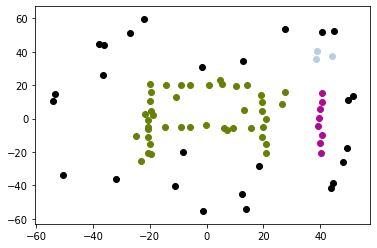

In [3]:
datapoints = parse_dataset('dbscan.csv', 'x', 'y')
clusters_map, noise = dbscan(datapoints, epsilon=7.5, min_points=3)
plot(clusters_map, noise)

## Problem 6: DBSCAN on toy raw data

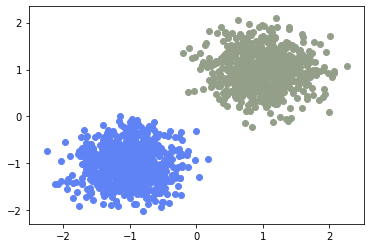

In [4]:
datapoints = parse_dataset('blobs.csv', 'Xblobs_X1', 'Xblobs_X2')
clusters_map, noise = dbscan(datapoints, epsilon=0.4, min_points=3)
plot(clusters_map, noise)

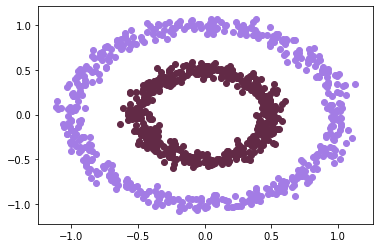

In [5]:
datapoints = parse_dataset('circle.csv', 'Xcircle_X1', 'Xcircle_X2')
clusters_map, noise = dbscan(datapoints, epsilon=0.1, min_points=3)
plot(clusters_map, noise)

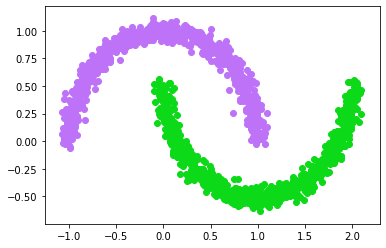

In [6]:
datapoints = parse_dataset('moons.csv', 'Xmoons_X1', 'Xmoons_X2')
clusters_map, noise = dbscan(datapoints, epsilon=0.2, min_points=3)
plot(clusters_map, noise)

## Problem 7: DBSCAN on real data

In [4]:
import numpy as np
from collections import Counter
from keras.datasets import fashion_mnist
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

In [5]:
def evaluate_purity_score(testing_set, true_labels, clusters_map):
    sum_count = 0
    for values in clusters_map.values():
        cluster_labels = [true_labels[v] for v in values]
        # print(Counter(cluster_labels).most_common()[0][1])
        sum_count += Counter(cluster_labels).most_common()[0][1]
    return sum_count / len(testing_set)

# calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.
# silhouette coefficient: (b - a) / max(a, b)
def evaluate_silhouette_score(testing_set, clusters_map):
    label_val = 0
    X, labels = [], []
    for key, values in clusters_map.items():
        for value in values:
            X.append(testing_set[value])
            labels.append(label_val)
        label_val += 1
    print(silhouette_score(X, labels))

# def evaluate_silhouette_score(X_test, y_test, clusters_map):
#     for key, values in clusters_map.items():
#         X, labels = [], []
#         for value in values:
#             X.append(X_test[value])
#             labels.append(y_test[value])
#         print(silhouette_score(X, labels))

### Fashion dataset

In [9]:
(X_train, y_train) , (X_test, y_test)= fashion_mnist.load_data()

X_train = normalize(X_train.flatten().reshape(60000, 784))
X_test = normalize(X_test.flatten().reshape(10000, 784))

In [10]:
X_test = X_test[:1000]
y_test = y_test[:1000]
print(X_test.shape)
print(y_test.shape)

(1000, 784)
(1000,)


In [11]:
clusters_map, noise = dbscan(X_test, epsilon=.4, min_points=20)
print('purity score:', evaluate_purity_score(X_test, y_test, clusters_map))

purity score: 0.207


In [12]:
# clusters_map, noise = dbscan(X_test, epsilon=0.5, min_points=20)
clusters_map, noise = dbscan(X_test, epsilon=.5, min_points=20)
print('purity score:', evaluate_purity_score(X_test, y_test, clusters_map))

purity score: 0.217


In [13]:
clusters_map, noise = dbscan(X_test, epsilon=.6, min_points=20)
print('purity score:', evaluate_purity_score(X_test, y_test, clusters_map))

purity score: 0.113


### Newsgroups dataset

In [15]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

categories = ['alt.atheism', 'talk.religion.misc','comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',categories=categories)
newsgroups_label = fetch_20newsgroups(subset='train',categories=categories).target
vectorizer = TfidfVectorizer()
newsgroups_train = vectorizer.fit_transform(newsgroups_train.data).todense()

In [16]:
newsgroups_train.shape

(2034, 34118)

In [17]:
clusters_map, noise = dbscan(newsgroups_train, epsilon=1.2, min_points=15)
print('purity score:', evaluate_purity_score(newsgroups_train, newsgroups_label, clusters_map))

purity score: 0.21730580137659783


In [22]:
clusters_map, noise = dbscan(newsgroups_train, epsilon=1.2, min_points=13)
print('purity score:', evaluate_purity_score(newsgroups_train, newsgroups_label, clusters_map))

purity score: 0.21042281219272368


In [23]:
clusters_map, noise = dbscan(newsgroups_train, epsilon=1.2, min_points=10)
print('purity score:', evaluate_purity_score(newsgroups_train, newsgroups_label, clusters_map))

purity score: 0.2182890855457227


### Household dataset

In [3]:
def parse_dataset_household(filename):
    count = 0
    datapoints = []
    with open(filename) as f:
        for i in range(2):
            line = f.readline()
        while line:
            count += 1
            vals = line.split(';')
            datapoints.append([float(v) for v in vals[2:]])
            if count == 5000:
                break
            # datapoints.append([float(vals[0]), float(vals[1])])
            line = f.readline()
    return np.array(datapoints)

In [12]:
clusters_map, noise = dbscan(datapoints, epsilon=5, min_points=5)

print('silhouette score for epsilon 5 & min points 5')
evaluate_silhouette_score(datapoints, clusters_map)

silhouette score for epsilon 5 & min points 5
0.49681084011930365


In [13]:
clusters_map, noise = dbscan(datapoints, epsilon=10, min_points=5)

print('silhouette score for epsilon 10 & min points 5')
evaluate_silhouette_score(datapoints, clusters_map)

silhouette score for epsilon 10 & min points 5
0.6178401157518751


In [14]:
clusters_map, noise = dbscan(datapoints, epsilon=15, min_points=5)

print('silhouette score for epsilon 15 & min points 5')
evaluate_silhouette_score(datapoints, clusters_map)

silhouette score for epsilon 15 & min points 5
0.7438006948347168


#### DBSCAN works well in low-dimensional and high-density data
#### DBSCAN does not work well in high-dimensional and varying-density data

## Problem 8: Hierarchical Clustering

In [1]:
import numpy as np

from sklearn import metrics
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
print(X_train.shape)    ## train images
print(y_train.shape)    ## train labels
print(X_test.shape)     ## test images
print(y_test.shape)     ## test labels

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [2]:
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred) # compute contingency matrix (confusion matrix)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [3]:
X_test = X_test[:2000]
X_test_distances = euclidean_distances(X_test)
X_test_distances.shape

(2000, 2000)

In [5]:
# X_test_distances

In [4]:
linkage_matrix = linkage(X_test_distances, 'ward')

In [28]:
cluster_labels = fcluster(linkage_matrix, t=0.7, criterion='inconsistent')
purity_score(y_test[:2000], cluster_labels)

0.948

In [5]:
cluster_labels = fcluster(linkage_matrix, t=0.8, criterion='inconsistent')
purity_score(y_test[:2000], cluster_labels)

0.915

In [6]:
cluster_labels = fcluster(linkage_matrix, t=0.9, criterion='inconsistent')
purity_score(y_test[:2000], cluster_labels)

0.9145

In [7]:
cluster_labels = fcluster(linkage_matrix, t=1.0, criterion='inconsistent')
purity_score(y_test[:2000], cluster_labels)

0.909

In [8]:
cluster_labels = fcluster(linkage_matrix, t=1.1, criterion='inconsistent')
purity_score(y_test[:2000], cluster_labels)

0.8815

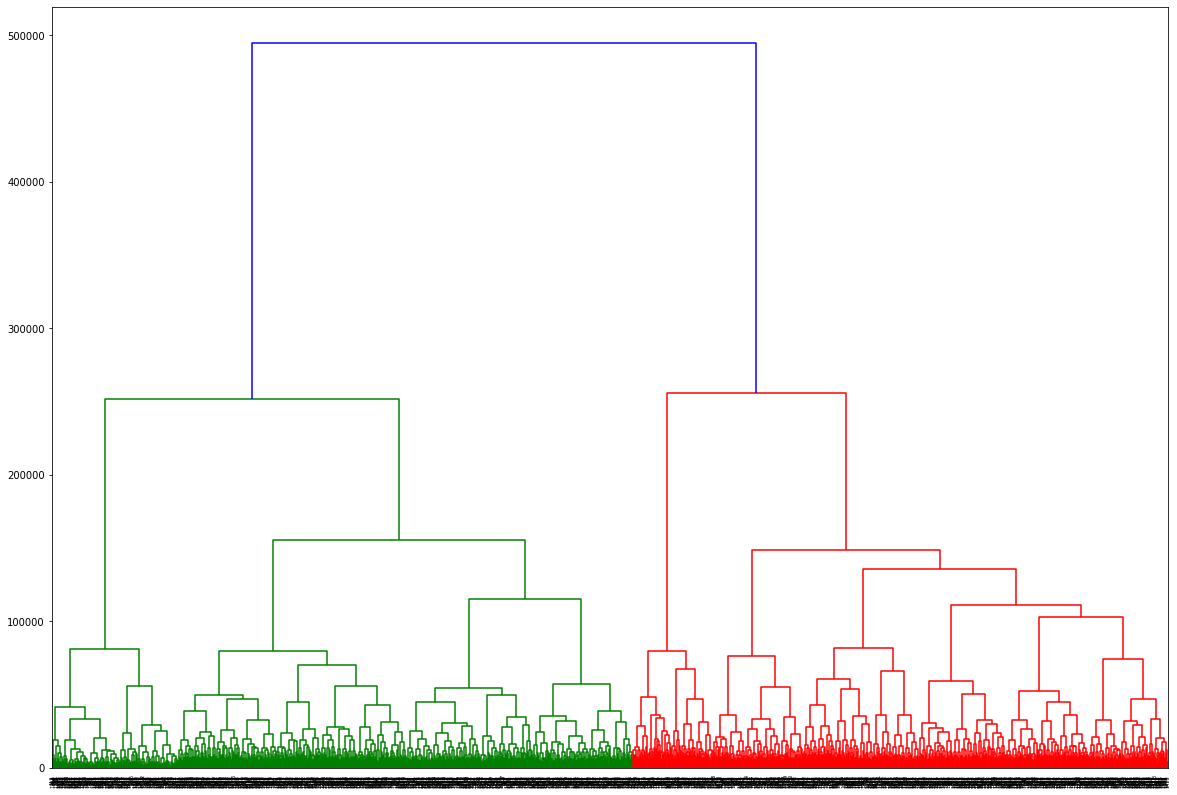

In [16]:
linkage_matrix = linkage(X_test_distances, 'ward')

plt.figure(figsize=(20, 14))
dendrogram(linkage_matrix)
plt.show()